In [95]:
library(RBGL)
library(ggplot2)
library(dplyr, warn.conflicts = FALSE)
#library(tibble)
library("rjson")

source("lib/code_for_binary_simulations/blip_vs_bidag_plot.R")
source("lib/code_for_binary_simulations/summarySE.R")

In [96]:
config <- fromJSON(file = "config.json")

In [97]:
directory <- config$output_dir
dims <- config$dims[[1]]
sample_sizes <- config$sample_sizes[[1]]
replicates <- config$replicates$start:config$replicates$end
avparents <-config$av_parents[[1]]

In [98]:
sample_sizes

[1] 320

In [99]:
config

$output_dir
[1] "simresults"

$replicates
$replicates$start
[1] 1

$replicates$end
[1] 100


$sample_sizes
[1] 320

$av_parents
$av_parents[[1]]
[1] 2 3


$dims
[1] 80

$blip
$blip$scorer.method
[1] "is"

$blip$solver.method
[1] "winasobs"

$blip$indeg
[1] 80

$blip$time
[1]  60 120

$blip$allocated
[1] 80

$blip$scorefunction
[1] "bdeu"

$blip$alpha
[1] 1

$blip$cores
[1] 1

$blip$verbose
[1] 0

$blip$bdecatpar.chi
[1] 1

$blip$bdecatpar.edgepf
[1] 1


$gobnilp
$gobnilp$plot
[1] FALSE

$gobnilp$palim
[1] 2


$pcalg
$pcalg$alpha
[1] 0.01 0.05 0.10 0.20 0.35 0.45


$mmhc
$mmhc$restrict.args
$mmhc$restrict.args$alpha
[1] 0.01 0.05 0.10 0.20 0.35 0.45



$itsearch_map
$itsearch_map$optional
$itsearch_map$optional$plus1it
NULL

$itsearch_map$optional$MAP
[1] 1

$itsearch_map$optional$posterior
NULL


$itsearch_map$score_params
$itsearch_map$score_params$bdepar
$itsearch_map$score_params$bdepar$chi
[1] 1

$itsearch_map$score_params$bdepar$edgepf
[1] 1




$itsearch_sample
$itsearch_sample$optional
$itsearch_sample$optional$MAP
[1] 0

$itsearch_sample$optional$plus1it
[1] 6

$itsearch_sample$optional$posterior
[1] 0.5


$itsearch_sample$score_params
$itsearch_sample$score_params$bdepar
$itsearch_sample$score_params$bdepar$chi
[1] 1

$itsearch_sample$score_params$bdepar$edgepf
[1] 1




$ordermcmc_map
$ordermcmc_map$startspace
[1] "itsearch_map"

$ordermcmc_map$optional
$ordermcmc_map$optional$plus1
[1] TRUE


$ordermcmc_map$score_params
$ordermcmc_map$score_params$bdepar
$ordermcmc_map$score_params$bdepar$chi
[1] 1

$ordermcmc_map$score_params$bdepar$edgepf
[1] 1




$ordermcmc_sample
$ordermcmc_sample$startspace
[1] "itsearch_sample"

$ordermcmc_sample$optional
$ordermcmc_sample$optional$plus1
[1] TRUE


$ordermcmc_sample$score_params
$ordermcmc_sample$score_params$bdepar
$ordermcmc_sample$score_params$bdepar$chi
[1] 1

$ordermcmc_sample$score_params$bdepar$edgepf
[1] 1

### Order MCMC

In [100]:
filenames <- list.files(pattern = "^(res_orderMCMC)", path = directory)
ROCdf_order_mcmc <- data.frame()
tmpdf <- 1
for (filename in filenames) {
    tmpdf <- read.csv(file.path(directory, filename))
    ROCdf_order_mcmc <- dplyr::bind_rows(ROCdf_order_mcmc, tmpdf)
}

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“bi

In [101]:
ROCdf_order_mcmc$algorithm <- apply(ROCdf_order_mcmc["itsearch_MAP"], 1, 
 function(a){
    if(a==TRUE){ 
        return("order_mcmc_itsearch_map")
     }else {
        return("order_mcmc_itsearch_sample")
      }
  })                                          

In [102]:
ROCdf_order_mcmc

TPR,FPRn,logscore,threshold,SHD,time,avparents,replicate,algorithm,dim,⋯,iterations,stepwise,alpha,cpdag,gamma,hardlimit,chainout,scoreout,verbose,itsearch_MAP
<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<chr>,<int>,⋯,<lgl>,<lgl>,<dbl>,<fct>,<int>,<int>,<fct>,<fct>,<fct>,<int>
0.00,0.00,-673.8440,0.99,20,1.937879,3,1,order_mcmc_itsearch_map,10,⋯,NA,NA,0.05,False,1,15,True,False,False,1
0.15,0.00,-583.0588,0.95,18,1.937879,3,1,order_mcmc_itsearch_map,10,⋯,NA,NA,0.05,False,1,15,True,False,False,1
0.15,0.00,-583.0588,0.90,18,1.937879,3,1,order_mcmc_itsearch_map,10,⋯,NA,NA,0.05,False,1,15,True,False,False,1
0.25,0.00,-533.0523,0.80,16,1.937879,3,1,order_mcmc_itsearch_map,10,⋯,NA,NA,0.05,False,1,15,True,False,False,1
0.30,0.00,-497.6349,0.70,16,1.937879,3,1,order_mcmc_itsearch_map,10,⋯,NA,NA,0.05,False,1,15,True,False,False,1
0.45,0.05,-369.6750,0.60,16,1.937879,3,1,order_mcmc_itsearch_map,10,⋯,NA,NA,0.05,False,1,15,True,False,False,1
0.45,0.10,-367.3596,0.50,17,1.937879,3,1,order_mcmc_itsearch_map,10,⋯,NA,NA,0.05,False,1,15,True,False,False,1
0.50,0.10,-362.8420,0.40,17,1.937879,3,1,order_mcmc_itsearch_map,10,⋯,NA,NA,0.05,False,1,15,True,False,False,1
0.55,0.15,NA,0.30,16,1.937879,3,1,order_mcmc_itsearch_map,10,⋯,NA,NA,0.05,False,1,15,True,False,False,1


In [103]:
sumROC_order_mcmc = ROCdf_order_mcmc %>%
                    filter(dim %in% dims) %>%
                    filter(sample_size %in% sample_sizes) %>%                    
                    filter(avparents %in% avparents) %>%       
                    filter(replicate %in% replicates) %>%
                    group_by(algorithm, threshold, sample_size, dim, avparents) %>% 
                    summarise( SHD_mean = mean(SHD),
                                TPR_mean = mean(TPR), 
                              TPR_median = median(TPR), 
                              FPRn_median = median(FPRn), 
                              TPR_q1 = quantile(TPR, probs = c(0.05)), 
                              TPR_q3 = quantile(TPR, probs = c(0.95)),
                              time_mean = mean(time),
                              logscore_mean = mean(logscore),
                              N = n()) %>%
                    filter(N %in% length(replicates))

In [104]:
sumROC_order_mcmc

algorithm,threshold,sample_size,dim,avparents,SHD_mean,TPR_mean,TPR_median,FPRn_median,TPR_q1,TPR_q3,time_mean,logscore_mean,N
<chr>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
order_mcmc_itsearch_map,0.20,320,80,2,58.19,0.9437635,0.9500000,0.341772152,0.8870274,0.9873418,32.30957,NA,100
order_mcmc_itsearch_map,0.20,320,80,3,79.35,0.8223148,0.8301887,0.174456522,0.6850577,0.9050931,34.80663,NA,100
order_mcmc_itsearch_map,0.30,320,80,2,49.94,0.9368691,0.9493671,0.226424051,0.8749209,0.9873418,32.30957,NA,100
order_mcmc_itsearch_map,0.30,320,80,3,71.55,0.8090620,0.8138882,0.119875010,0.6682845,0.8987342,34.80663,NA,100
order_mcmc_itsearch_map,0.40,320,80,2,46.38,0.9306259,0.9375000,0.151898734,0.8617801,0.9873418,32.30957,NA,100
order_mcmc_itsearch_map,0.40,320,80,3,67.75,0.7974475,0.8044145,0.093171296,0.6536621,0.8863924,34.80663,NA,100
order_mcmc_itsearch_map,0.50,320,80,2,44.46,0.9206234,0.9367089,0.101265823,0.8248892,0.9873418,32.30957,-12143.89,100
order_mcmc_itsearch_map,0.50,320,80,3,65.23,0.7854397,0.7924528,0.068966195,0.6411705,0.8860759,34.80663,NA,100
order_mcmc_itsearch_map,0.60,320,80,2,42.63,0.8650135,0.8750000,0.063291139,0.7615701,0.9388264,32.30957,-12323.07,100


### PC algorithm

In [105]:
filenames <- list.files(pattern = "^(res_pcalg)", path = directory)
roc_pcalg <- data.frame()
for (filename in filenames) {
  tmpdf <- read.csv(file.path(directory, filename))
  roc_pcalg <- dplyr::bind_rows(roc_pcalg, tmpdf)
}

In [107]:
sum_roc_pcalg <- roc_pcalg %>% 
                 filter(dim %in% dims) %>%
                 filter(sample_size %in% sample_sizes) %>%         
                 filter(avparents %in% avparents) %>%
                filter(replicate %in% replicates) %>%
                 group_by(algorithm, alpha, sample_size, dim, avparents) %>% 
                 summarise(
                          SHD_mean = mean(SHD),
                          TPR_mean = mean(TPR), 
                          TPR_median = median(TPR), 
                          FPRn_median = median(FPRn), 
                          TPR_q1 = quantile(TPR, probs = c(0.05)), 
                          TPR_q3 = quantile(TPR, probs = c(0.95)),
                          time_mean = mean(time),
                          N = n())# %>% ungroup() %>%
#                 filter(N %in% replicates)

In [110]:
sum_roc_pcalg

algorithm,alpha,sample_size,dim,avparents,SHD_mean,TPR_mean,TPR_median,FPRn_median,TPR_q1,TPR_q3,time_mean,N
<fct>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
pcalg,0.01,320,80,2,43.12,0.7580607,0.7594937,0.01250000,0.6750000,0.8360759,10.66220,100
pcalg,0.01,320,80,3,124.43,0.4609463,0.4656237,0.00000000,0.3753608,0.5281153,41.36418,100
pcalg,0.05,320,80,2,44.99,0.7977128,0.8000000,0.06329114,0.7087836,0.8734177,14.22839,100
pcalg,0.05,320,80,3,118.11,0.5087553,0.5125000,0.01250000,0.4298799,0.5696203,68.35122,100
pcalg,0.10,320,80,2,51.53,0.8128865,0.8176424,0.13750000,0.7210680,0.8862166,18.63960,100
pcalg,0.10,320,80,3,116.42,0.5293571,0.5360456,0.01898734,0.4491210,0.5949445,97.99845,100
pcalg,0.20,320,80,2,59.50,0.8324512,0.8364715,0.21518987,0.7334440,0.9017425,34.48556,100
pcalg,0.20,320,80,3,115.22,0.5539509,0.5559028,0.04084741,0.4647498,0.6268483,156.79301,100
pcalg,0.35,320,80,2,68.41,0.8462253,0.8500000,0.32500000,0.7621799,0.9115018,77.09250,100


### Max-Min hill climbing

In [111]:
filenames <- list.files(pattern = "^(res_mmhc)", path = directory)
roc_mmhc <- data.frame()
for (filename in filenames) {
  tmpdf <- read.csv(file.path(directory, filename))
  roc_mmhc <- dplyr::bind_rows(roc_mmhc, tmpdf)
}

In [112]:
sum_roc_mmhc <- roc_mmhc %>% 
                filter(dim %in% dims) %>%
                filter(sample_size %in% sample_sizes) %>%
                    filter(avparents %in% avparents) %>% 
                filter(replicate %in% replicates) %>%
                 group_by(algorithm, alpha, sample_size, dim, avparents) %>% 
                 summarise( SHD_mean = mean(SHD),
                           TPR_mean = mean(TPR), 
                          TPR_median = median(TPR), 
                          FPRn_median = median(FPRn), 
                          TPR_q1 = quantile(TPR, probs = c(0.05)), 
                          TPR_q3 = quantile(TPR, probs = c(0.95)),
                           time_mean = mean(time),
                          N = n()) #%>% ungroup() %>%
                    #filter(N %in% replicates)

In [113]:
sum_roc_mmhc

algorithm,alpha,sample_size,dim,avparents,SHD_mean,TPR_mean,TPR_median,FPRn_median,TPR_q1,TPR_q3,time_mean,N
<fct>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
mmhc,0.01,320,80,2,40.06,0.7672209,0.7687920,0.01250000,0.6872713,0.8481013,0.6072386,100
mmhc,0.01,320,80,3,106.44,0.4742666,0.4795000,0.00000000,0.3944630,0.5344974,0.7363792,100
mmhc,0.05,320,80,2,40.92,0.8075093,0.8125000,0.05063291,0.7373339,0.8860759,0.6423155,100
mmhc,0.05,320,80,3,102.25,0.5156635,0.5173368,0.01223253,0.4299299,0.5763972,0.7954918,100
mmhc,0.10,320,80,2,41.84,0.8220456,0.8271605,0.08695988,0.7498418,0.8987975,0.6723666,100
mmhc,0.10,320,80,3,100.61,0.5334995,0.5362659,0.01265823,0.4427215,0.6053439,0.8596484,100
mmhc,0.20,320,80,2,42.48,0.8350988,0.8375000,0.10063291,0.7588608,0.9005696,0.7415464,100
mmhc,0.20,320,80,3,99.53,0.5500061,0.5527950,0.01898734,0.4608635,0.6203726,0.9255760,100
mmhc,0.35,320,80,2,42.55,0.8409681,0.8457374,0.11250000,0.7498418,0.9005696,0.8473778,100


### Iterative MCMC

In [114]:
filenames <- list.files(pattern = "^(res_itsearch)", path = directory)
ROCdf_itsearch <- data.frame()
for (filename in filenames) {
  tmpdf <- read.csv(file.path(directory, filename))
  # Convert "None" string to NA
    tmpdf["plus1it"] <- na_if(tmpdf["plus1it"], "None")
   tmpdf["posterior"] <- na_if(tmpdf["posterior"], "None")
    ROCdf_itsearch <- dplyr::bind_rows(ROCdf_itsearch, tmpdf)
  
}

In [115]:
ROCdf_itsearch$algorithm <- apply(ROCdf_itsearch["MAP"], 1, 
 function(a){
    if(a==TRUE){ 
        return("itsearch_map")
     }else {
        return("itsearch_sample")
      }
  })                                          

In [116]:
sum_roc_itsearch <- ROCdf_itsearch %>% 
                filter(dim %in% dims) %>%
                filter(sample_size %in% sample_sizes) %>%
                filter(avparents %in% avparents) %>%
                filter(replicate %in% replicates) %>%                
                 group_by(algorithm, sample_size, dim, avparents) %>% 
                 summarise( SHD_mean = mean(SHD),
                           TPR_mean = mean(TPR), 
                          TPR_median = median(TPR), 
                          FPRn_median = median(FPRn), 
                          TPR_q1 = quantile(TPR, probs = c(0.05)), 
                          TPR_q3 = quantile(TPR, probs = c(0.95)),
                          logscore_mean =  mean(logscore),
                           time_mean = mean(time),
                           it_mean = mean(it),
                          N = n()) %>%
                    filter(N %in% length(replicates))

In [117]:
sum_roc_itsearch

algorithm,sample_size,dim,avparents,SHD_mean,TPR_mean,TPR_median,FPRn_median,TPR_q1,TPR_q3,logscore_mean,time_mean,it_mean,N
<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
itsearch_map,320,80,2,53.09,0.9395195,0.9493671,0.3312236,0.8750000,0.9873418,-12118.38,99.08674,3.85,100
itsearch_map,320,80,3,73.89,0.8038138,0.8113208,0.1312500,0.6685782,0.8880617,-10623.70,157.62743,5.20,100
itsearch_sample,320,80,3,77.09,0.7949864,0.8095219,0.1514211,0.6586599,0.8870388,-10654.06,294.05875,5.00,100


### Blip

In [118]:
filenames <- list.files(pattern = "^(res_blip)", path = directory)
ROCdf_blip <- data.frame()
for (filename in filenames) {
  tmpdf <- read.csv(file.path(directory, filename))
  ROCdf_blip <- dplyr::bind_rows(ROCdf_blip, tmpdf)
}

In [119]:
ROCdf_blip

TPR,FPRn,logscore,SHD,time,avparents,replicate,algorithm,dim,sample_size,⋯,scorer.method,solver.method,indeg,cores,allocated,scorefunction,alpha,verbose,bdecatpar.chi,bdecatpar.edgepf
<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<fct>,<int>,<int>,⋯,<fct>,<fct>,<int>,<int>,<int>,<fct>,<int>,<int>,<int>,<int>
0.5000000,0.1500000,-361.7887,17,25.342268,3,1,blip,10,100,⋯,is,winasobs,80,1,80,bdeu,1,0,1,1
0.5500000,0.1000000,-449.4686,15,25.271959,3,2,blip,10,100,⋯,is,winasobs,80,1,80,bdeu,1,0,1,1
0.5000000,0.1500000,-361.7887,17,5.577586,3,1,blip,10,100,⋯,is,winasobs,80,1,80,bdeu,1,0,1,1
0.5500000,0.1000000,-449.4686,16,13.393306,3,2,blip,10,100,⋯,is,winasobs,80,1,80,bdeu,1,0,1,1
1.0000000,0.0000000,-219.5077,1,25.268135,2,1,blip,5,100,⋯,is,winasobs,80,1,80,bdeu,1,0,1,1
0.8000000,0.0000000,-289.2075,3,25.287322,2,2,blip,5,100,⋯,is,winasobs,80,1,80,bdeu,1,0,1,1
1.0000000,0.0000000,-219.5077,1,13.273954,2,1,blip,5,100,⋯,is,winasobs,80,1,80,bdeu,1,0,1,1
0.8000000,0.0000000,-289.2075,2,13.213770,2,2,blip,5,100,⋯,is,winasobs,80,1,80,bdeu,1,0,1,1
0.6666667,0.0000000,-175.9731,5,25.310608,3,1,blip,5,100,⋯,is,winasobs,80,1,80,bdeu,1,0,1,1


In [120]:
sum_roc_blip <- ROCdf_blip %>% 
                filter(dim %in% dims) %>%
                filter(sample_size %in% sample_sizes) %>%
                filter(avparents %in% avparents) %>%      
                filter(replicate %in% replicates) %>%
                filter(indeg %in% config$blip$indeg) %>%
                 group_by(algorithm, sample_size, dim,max_time, avparents) %>% 
                 summarise( SHD_mean = mean(SHD),
                           TPR_mean = mean(TPR),
                          time_mean=mean(time),
                          TPR_median = median(TPR), 
                          FPRn_median = median(FPRn), 
                          TPR_q1 = quantile(TPR, probs = c(0.05)),
                          TPR_q3 = quantile(TPR, probs = c(0.95)),
                           logscore_mean = mean(logscore),
                          N = n())#%>%
                    #filter(N %in% replicates)

In [121]:
sum_roc_blip

algorithm,sample_size,dim,max_time,avparents,SHD_mean,TPR_mean,time_mean,TPR_median,FPRn_median,TPR_q1,TPR_q3,logscore_mean,N
<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
blip,320,80,60,2,61.08,0.9416341,62.02921,0.9500000,0.4936709,0.8745427,0.9873418,-12105.87,100
blip,320,80,60,3,74.24,0.8083734,61.86613,0.8164557,0.1593608,0.6705652,0.8870731,-10622.97,100
blip,320,80,120,2,61.77,0.9425291,122.02307,0.9500000,0.5063291,0.8874288,0.9875000,-12104.23,100
blip,320,80,120,3,75.97,0.8092521,121.73237,0.8124927,0.1729438,0.6727477,0.8939992,-10618.46,100


### GoBNiLP

In [455]:
filenames <- list.files(pattern = "^(res_gobnilp)", path = directory)
ROCdf_gobnilp <- data.frame()
for (filename in filenames) {
  tmpdf <- read.csv(file.path(directory, filename))
  ROCdf_gobnilp <- dplyr::bind_rows(ROCdf_gobnilp, tmpdf)
}

In [456]:
ROCdf_gobnilp

<0 x 0 matrix>

In [457]:
#sum_roc_gobnilp <- ROCdf_gobnilp %>% 
#                filter(dim %in% dims) %>%
#                    filter(sample_size %in% sample_sizes) %>%
#                    filter(avparents %in% avparents) %>%          
#                filter(replicate %in% replicates) %>%
#                   group_by(algorithm, sample_size, dim, avparents, palim) %>% 
#                 summarise( SHD_mean = mean(SHD),
#                     TPR_mean = mean(TPR), 
#                          TPR_median = median(TPR), 
#                          FPRn_median = median(FPRn), 
#                          TPR_q1 = quantile(TPR, probs = c(0.05)),
#                          TPR_q3 = quantile(TPR, probs = c(0.95)),
#                           time_mean = mean(time),
#                          N = n())%>%
#                    filter(N %in% length(replicates))

In [458]:
#sum_roc_gobnilp

## Plot ROC curves

Warning message:
“The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 7. Consider
specifying shapes manually if you must have them.”
Warning message:
“Removed 12 rows containing missing values (geom_point).”
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

Saving 6.67 x 6.67 in image

Warning message:
“The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 7. Consider
specifying shapes manually if you must have them.”
Warning message:
“Removed 12 rows containing missing values (geom_point).”
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



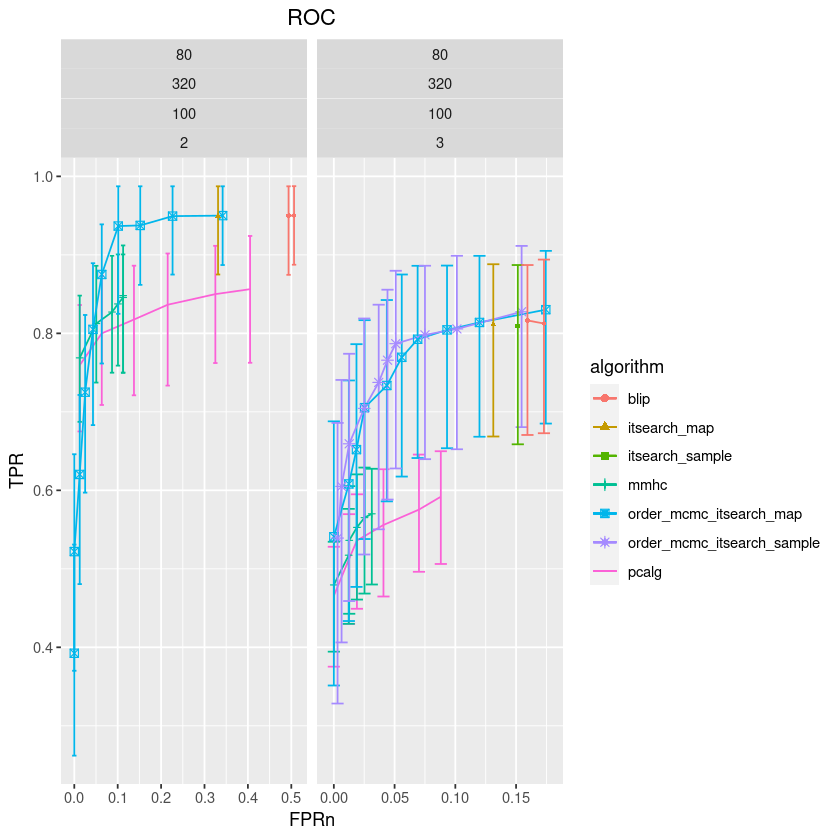

In [122]:
ggplot() +
# PC algorithm
geom_errorbar(data = sum_roc_pcalg,
              aes(x = FPRn_median,
                  ymin = TPR_q1, 
                  ymax = TPR_q3, 
                  col = algorithm), 
              width = 0.01) +
geom_path(data = sum_roc_pcalg,
          aes(x = FPRn_median, 
              y = TPR_median,
              col = algorithm)) +
geom_point(data = sum_roc_pcalg,
           aes(x = FPRn_median, 
               y = TPR_median,               
               col = algorithm, 
               shape = algorithm), 
               size = 1) + 
# geom_text(data = sum_roc_pcalg,
#            aes(x = FPRn_median, 
#                y = TPR_q3,               
#                label=alpha, col=algorithm),
#          check_overlap = TRUE,
#           nudge_x=-0.02,
#          nudge_y=0.02
#          ) +

# Max-min hill- climbing 
geom_errorbar(data = sum_roc_mmhc,
              aes(x = FPRn_median,
                  ymin = TPR_q1, 
                  ymax = TPR_q3, 
                  col = algorithm), 
              width = 0.01) +
geom_path(data = sum_roc_mmhc,
          aes(x = FPRn_median, 
              y = TPR_median,
              col = algorithm)) +
geom_point(data = sum_roc_mmhc,
           aes(x = FPRn_median, 
               y = TPR_median,               
               col = algorithm, 
               shape = algorithm), 
               size = 1) + 
# geom_text(data = sum_roc_mmhc,
#            aes(x = FPRn_median, 
#                y = TPR_q3,               
#                label=alpha, col=algorithm),
#          check_overlap = TRUE,
#           nudge_x=-0.02,
#          nudge_y=0.02
#          ) +

# Order mcmc
geom_errorbar(data = sumROC_order_mcmc,
              aes(x = FPRn_median,
                  ymin = TPR_q1, 
                  ymax = TPR_q3, 
                  col = algorithm), 
              width = 0.01) +
geom_path(data = sumROC_order_mcmc,
          aes(x = FPRn_median, 
              y = TPR_median,
              col = algorithm)) +
geom_point(data = sumROC_order_mcmc,
           aes(x = FPRn_median, 
               y = TPR_median,               
               col = algorithm, 
               shape = algorithm), 
               size = 2) +
# geom_text(data = sumROC_order_mcmc,
#            aes(x = FPRn_median, 
#                y = TPR_q3,               
#                col = algorithm, label=threshold),
#            check_overlap = TRUE,
#           nudge_x=-0.02,
#          nudge_y=0.02) +

# Iterative search
geom_errorbar(data = sum_roc_itsearch,
              aes(x = FPRn_median,
                  ymin = TPR_q1, 
                  ymax = TPR_q3, 
                  col = algorithm), 
              width = 0.01) +
geom_path(data = sum_roc_itsearch,
          aes(x = FPRn_median, 
              y = TPR_median,
              col = algorithm)) +
geom_point(data = sum_roc_itsearch,
           aes(x = FPRn_median, 
               y = TPR_median,               
               col = algorithm, 
               shape = algorithm), 
               size = 1) +
# Blip
geom_errorbar(data = sum_roc_blip,
              aes(x = FPRn_median,
                  ymin = TPR_q1, 
                  ymax = TPR_q3, 
                  col = algorithm), 
              width = 0.01) +
geom_path(data = sum_roc_blip,
          aes(x = FPRn_median, 
              y = TPR_median,
              col = algorithm)) +
geom_point(data = sum_roc_blip,
           aes(x = FPRn_median, 
               y = TPR_median,               
               col = algorithm, 
               shape = algorithm), 
               size = 1) +
# Gobnilp
#geom_errorbar(data = sum_roc_gobnilp,
#               aes(x = FPRn_median,
#                   ymin = TPR_q1, 
#                   ymax = TPR_q3, 
#                   col = algorithm), 
#               width = 0.01) +
# geom_path(data = sum_roc_gobnilp,
#           aes(x = FPRn_median, 
#               y = TPR_median,
#               col = algorithm)) +
# geom_point(data = sum_roc_gobnilp,
#            aes(x = FPRn_median, 
#                y = TPR_median,               
#                col = algorithm, 
#                shape = algorithm), 
#                size = 1) +
## Subplot
facet_wrap(dim ~ sample_size + N + avparents, scales="free_x") +
# Titles etc
xlab("FPRn") +
ylab("TPR") +
ggtitle("ROC") +
theme(plot.title = element_text(hjust = 0.5))
ggsave(file=file.path("ROC.eps"))

Saving 6.67 x 6.67 in image



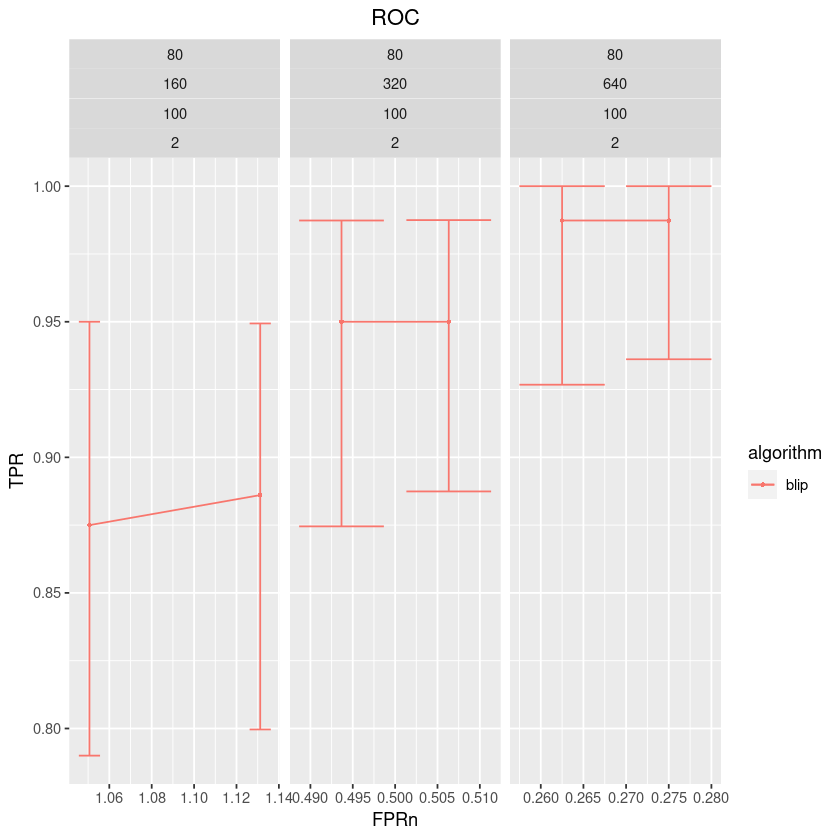

In [495]:
ggplot() +
# PC algorithm
geom_errorbar(data = sum_roc_blip,
              aes(x = FPRn_median,
                  ymin = TPR_q1, 
                  ymax = TPR_q3, 
                  col = algorithm), 
              width = 0.01) +
geom_path(data = sum_roc_blip,
          aes(x = FPRn_median, 
              y = TPR_median,
              col = algorithm)) +
geom_point(data = sum_roc_blip,
           aes(x = FPRn_median, 
               y = TPR_median,               
               col = algorithm, 
               shape = algorithm), 
               size = 1) +
# Gobnilp
#geom_errorbar(data = sum_roc_gobnilp,
#               aes(x = FPRn_median,
#                   ymin = TPR_q1, 
#                   ymax = TPR_q3, 
#                   col = algorithm), 
#               width = 0.01) +
# geom_path(data = sum_roc_gobnilp,
#           aes(x = FPRn_median, 
#               y = TPR_median,
#               col = algorithm)) +
# geom_point(data = sum_roc_gobnilp,
#            aes(x = FPRn_median, 
#                y = TPR_median,               
#                col = algorithm, 
#                shape = algorithm), 
#                size = 1) +
## Subplot
facet_wrap(dim ~ sample_size + N + avparents, scales="free_x") +
# Titles etc
xlab("FPRn") +
ylab("TPR") +
ggtitle("ROC") +
theme(plot.title = element_text(hjust = 0.5))
ggsave(file=file.path("ROC.eps"))

Saving 6.67 x 6.67 in image



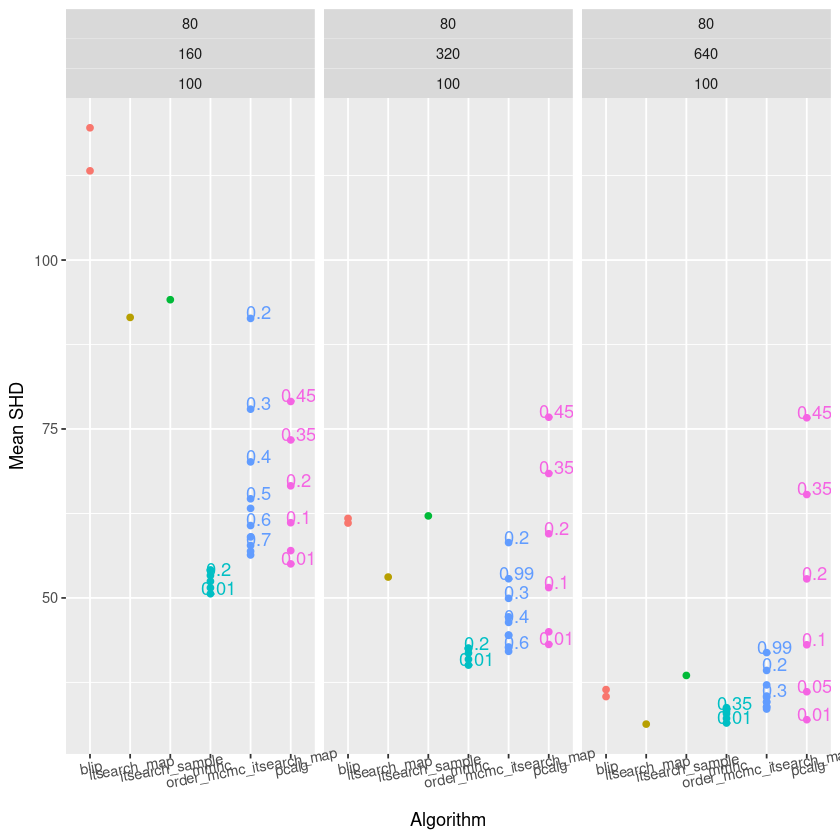

In [496]:
ggplot() + 
geom_point(data = sumROC_order_mcmc,
          aes(x = algorithm,
              y = SHD_mean,
              col = algorithm)) +
geom_text(data = sumROC_order_mcmc,
          aes(x = algorithm, 
               y = SHD_mean,               
                col = algorithm, label=threshold),
            check_overlap = TRUE,
           nudge_x=0.2,
          nudge_y=0.9) +

geom_point(data = sum_roc_pcalg,
          aes(x = algorithm,
              y = SHD_mean,
              col = algorithm)) +
geom_text(data = sum_roc_pcalg,
          aes(x = algorithm, 
               y = SHD_mean,               
                col = algorithm, label=alpha),
            check_overlap = TRUE,
           nudge_x=0.2,
          nudge_y=0.9) +

geom_point(data = sum_roc_mmhc,
          aes(x = algorithm,
              y = SHD_mean,
              col = algorithm)) +
geom_text(data = sum_roc_mmhc,
          aes(x = algorithm, 
               y = SHD_mean,               
                col = algorithm, label=alpha),
            check_overlap = TRUE,
           nudge_x=0.2,
          nudge_y=0.9) +

geom_point(data = sum_roc_blip,
          aes(x = algorithm,
              y = SHD_mean,
              col = algorithm)) +
geom_point(data = sum_roc_itsearch,
          aes(x = algorithm,
              y = SHD_mean,
              col = algorithm)) +
theme(axis.text.x = element_text(angle = 10), legend.position = "none") +
facet_wrap(dim ~ sample_size + N , scales="free_x") +
ylab("Mean SHD") +
xlab("Algorithm") 
ggsave(file=file.path("SHD.eps"))

## Logscores

Warning message:
“Removed 9 rows containing missing values (geom_point).”
Warning message:
“Removed 9 rows containing missing values (geom_text).”
Saving 6.67 x 6.67 in image

Warning message:
“Removed 9 rows containing missing values (geom_point).”
Warning message:
“Removed 9 rows containing missing values (geom_text).”


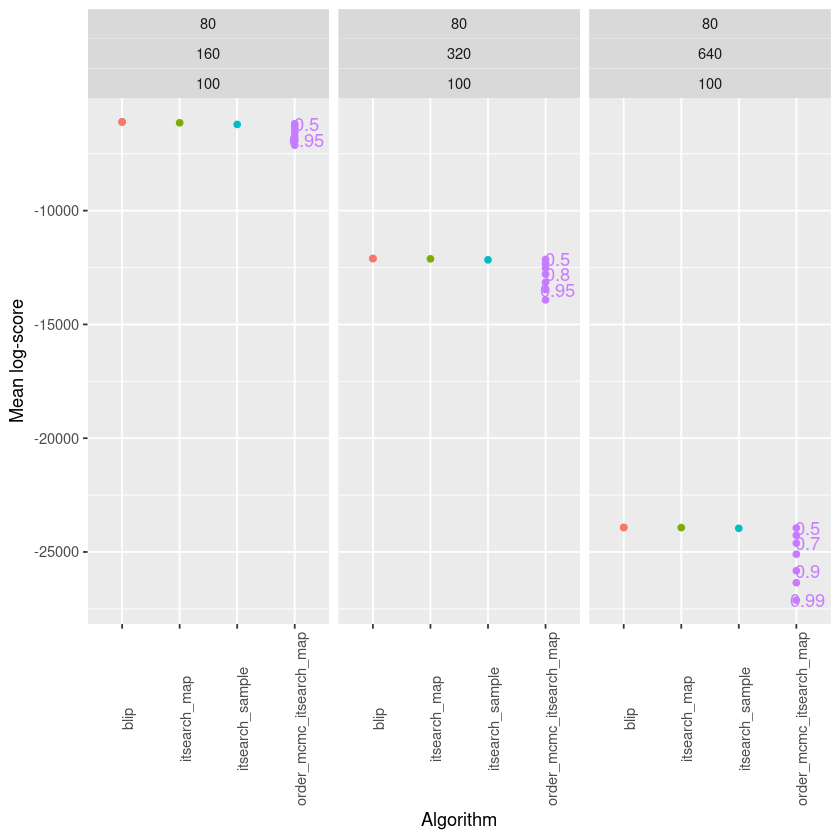

In [499]:
ggplot() + 
geom_point(data = sumROC_order_mcmc,
          aes(x = algorithm,
              y = logscore_mean,
              col = algorithm)) +
geom_text(data = sumROC_order_mcmc,
          aes(x = algorithm, 
               y = logscore_mean,               
                col = algorithm, label=threshold),
            check_overlap = TRUE,
           nudge_x=0.2,
          nudge_y=0.9) +

#geom_point(data = sum_roc_pcalg,
#          aes(x = algorithm,
#              y = logscore_mean,
#              col = algorithm)) +
#geom_point(data = sum_roc_mmhc,
#          aes(x = algorithm,
#              y = logscore_mean,
#              col = algorithm)) +
geom_point(data = sum_roc_blip,
          aes(x = algorithm,
              y = logscore_mean,
              col = algorithm)) +
geom_point(data = sum_roc_itsearch,
          aes(x = algorithm,
              y = logscore_mean,
              col = algorithm)) +
theme(axis.text.x = element_text(angle = 90),
      legend.position = "none") +
facet_wrap(dim ~ sample_size + N , scales="free_x") +
ylab("Mean log-score") +
xlab("Algorithm") 
ggsave(file=file.path("logscore.eps"))


## Times

Saving 6.67 x 6.67 in image



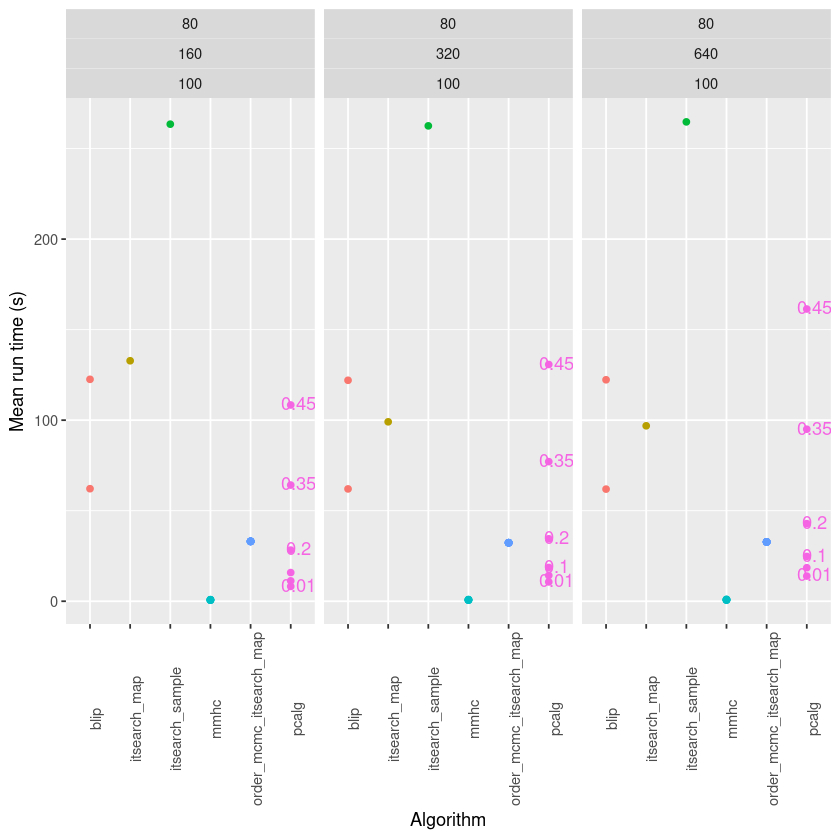

In [502]:
ggplot() + 
geom_point(data = sumROC_order_mcmc,
          aes(x = algorithm,
              y = time_mean,
              col = algorithm)) +
geom_point(data = sum_roc_pcalg,
          aes(x = algorithm,
              y = time_mean,
              col = algorithm)) +
geom_text(data = sum_roc_pcalg,
          aes(x = algorithm, 
               y = time_mean,               
                col = algorithm, label=alpha),
            check_overlap = TRUE,
           nudge_x=0.2,
          nudge_y=0.9) +

geom_point(data = sum_roc_mmhc,
          aes(x = algorithm,
              y = time_mean,
              col = algorithm)) +
geom_point(data = sum_roc_blip,
          aes(x = algorithm,
              y = time_mean,
              col = algorithm)) +
geom_point(data = sum_roc_itsearch,
          aes(x = algorithm,
              y = time_mean,
             col = algorithm)) +
theme(axis.text.x = element_text(angle = 90), legend.position = "none") +
facet_wrap(dim ~ sample_size + N , scales="free_x") +
ylab("Mean run time (s)") +
xlab("Algorithm") 
ggsave(file=file.path("runtimes.eps"))